In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.utils
from torchvision.utils import make_grid

import torchvision.datasets

import matplotlib.pyplot as plt 
plt.rcParams["figure.figsize"] = (10,6)

from tqdm import tqdm 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Introduction to GANs

In this notebook we will build a GAN from scratch, grossly following the DCGAN architecture. 

**Goals:**


1.   Build a GAN arhictecture from scratch
2.   Write the GAN loss function and train GAN from scratch
3.   Have experience with some of the instability problems inherent with training GANs.



## 1. Getting Started

We will work with the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. It contains 60,000 images size 28x28 of handwritten digits, from 0 to 9.

## 1. Dataloading

### 1.1 Define some hyperparameters and transforms


In [ ]:
batch_size = 128 # Images per batch

# Resize to 32x32 for easier upsampling/downsampling
mytransform = transforms.Compose([transforms.Resize(32),
                                  transforms.ToTensor(),
                                 transforms.Normalize((.5), (.5))]) # normalize between [-1, 1] with tanh activation

mnist_train = torchvision.datasets.MNIST(root='.', download=True, transform=mytransform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
dataloader = DataLoader(dataset=mnist_train, 
                         batch_size=batch_size,
                         shuffle=True)    

In [ ]:
# plot some images
real_batch, real_labels = next(iter(dataloader))

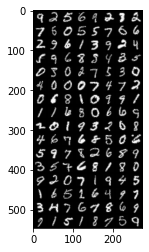

In [ ]:
plt.imshow(transforms.ToPILImage()(make_grid(real_batch)))

## 2. Model Architecture

We will follow the general architecture of a DCGAN - or deep convolutional GAN. This [influential paper](https://arxiv.org/pdf/1511.06434v2.pdf) produced much of the foundation for modern GANs and how to train them.

(GANs are notoriously **hard** to train, we will try to get a feeling why in this notebook.)


Input: Random "noise" $z$ shaped `[n_batch, n_z]`

Output: Generated image size `[n_batch, 1, 32, 32]` in range [-1, 1]

1. Reshape z into `[n_batch, n_z, 1, 1]` to make it into an "image"
2. First upscaling block $\rightarrow$ `[n_batch, ngf*4, 4, 4]`
3. Second upscaling block $\rightarrow$ `[n_batch, ngf*2, 8, 8]`
4. Third upscaling block $\rightarrow$ `[n_batch, ngf, 16, 16]`
5. Fourth (and last) upscaling block $\rightarrow$ `[n_batch, 1, 32, 32]`

## 2.1. The Generator



The generator performs subsequent upsampling blocks, transforming a latent vector shaped [batch_size, latent_size] into an image (values in [-1, 1]).

The generator block will consists of:
- Transpose Convolution
- Batch Norm 
- ReLU

In [ ]:
def get_upscaling_block(channels_in, channels_out, kernel, stride, padding, last_layer=False):
    '''
    Each transpose conv will be followed by BatchNorm and ReLU, 
    except the last block (which is only followed by tanh)
    '''
    if last_layer:
        
        seq = nn.Sequential(
                nn.ConvTranspose2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding, bias=False),
                nn.Tanh()
            )
    else:
        
        seq = nn.Sequential(
                nn.ConvTranspose2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding, bias=False), #bs,channel,img,img
                nn.BatchNorm2d(channels_out),
                nn.ReLU()
            )
    return seq



class Generator(nn.Module):
    def __init__(self, nz, ngf, nchannels=1):
        '''
        nz: The latent size (1000 in our case)
        ngf: The channel-size before the last layer (32 our case)
        '''
        super().__init__()
        
       
        
        self.model = nn.Sequential(
            *get_upscaling_block(nz,4*ngf, 4, 1, 0),
            *get_upscaling_block(4*ngf,2*ngf, 5, 1, 0),
            *get_upscaling_block(2*ngf,ngf, 4, 2, 1),
            *get_upscaling_block(ngf,1, 4, 2, 1,True),
            )
        
    def forward(self, z):
        x = z.unsqueeze(2).unsqueeze(2) # give spatial dimensions to z
        return self.model(x)
        

### 2.1.3. Sanity Tests

In [ ]:
nz = 1000
z = torch.randn(batch_size, nz)

In [ ]:
G = Generator(nz=nz, ngf=32)
print(G(z).shape)
assert G(z).shape == (batch_size, 1, 32, 32)

G = Generator(nz=nz, ngf=32)
assert G(z).shape == (batch_size, 1, 32, 32)

torch.Size([128, 1, 32, 32])


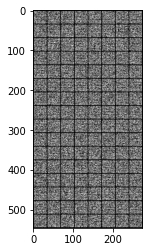

In [ ]:
# visualize the output
x_fake = G(z)
plt.imshow(transforms.ToPILImage()(make_grid(x_fake, nrow=8)))

## 2.2. The discriminator

The discriminator will be a mirror image of the generator. 

The discriminator will also use a fully convolutional architecutre, with each block consisting of:
- Conv layer
- BatchNorm
- ReLU

Input: Image shaped `[n_batch, 1, 32, 32]` (in [-1, 1])
Output: Discriminator scores `[n_batch, 1]` in range [0, 1]

1. First downscaling block $\rightarrow$ `[n_batch, ndf, 16, 16]`
2. Second downscaling block $\rightarrow$ `[n_batch, ndf*2, 8, 8]`
3. Third downscaling block $\rightarrow$ `[n_batch, ndf*4, 4, 4]`
4. Last downscaling block $\rightarrow$ `[n_batch, 1]` 

In [ ]:
def get_downscaling_block(channels_in, channels_out, kernel, stride, padding, use_batch_norm=True, is_last=False):
    
    if is_last:
    
        seq = nn.Sequential(
                nn.Conv2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding, bias=False),
                nn.Sigmoid()
            )
    
    elif not use_batch_norm:
       
        seq = nn.Sequential(
                nn.Conv2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding, bias=False), #bs,channel,img,img
                nn.ReLU()
            )
    
    else:
        
        seq = nn.Sequential(
                nn.Conv2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding, bias=False), #bs,channel,img,img
                nn.BatchNorm2d(channels_out),
                nn.ReLU()
            )
        
    return seq
    
    


class Discriminator(nn.Module):
    def __init__(self, ndf, nchannels=1):
        super().__init__()
        
        self.model = nn.Sequential(
            *get_downscaling_block(nchannels,ndf, 4, 2, 1),
            *get_downscaling_block(ndf,2*ndf, 4, 2, 1),
            *get_downscaling_block(2*ndf,4*ndf, 4, 2, 1),
            *get_downscaling_block(4*ndf,1, 4, 1, 0,True,True)
            )

    def forward(self, x):
        return self.model(x).squeeze(1).squeeze(1) # remove spatial dimensions

### 2.2.3 Sanity Checking

In [ ]:
real_batch, real_labels = next(iter(dataloader))

In [ ]:
D = Discriminator(ndf=32, nchannels=1)
print(D(real_batch)[0])
assert D(real_batch).shape == (real_batch.shape[0], 1)

tensor([0.5646], grad_fn=<SelectBackward0>)


# 3. Training

## 3.1 Loss 
The essential thing to remember is that the logistic and the non-saturating logistic GAN losses can be written exclusively using the [binary cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html). Our GAN loss will be defined ONLY using the following criterion:



In [ ]:
criterion = nn.BCELoss() # we will build off of this to make our final GAN loss!

## 3.2 Helper functions

We will need a few helper functions. 
1. First, we need to continuously sample z from a Gaussian distribution. 
2. Secondly, we need to make our "ground-truth" labels when using the BCE loss. This should output vectors of either 0s or 1s. 

In [ ]:
def sample_z(batch_size, nz):
    return torch.randn(batch_size, nz, device=device)

# this is for the real ground-truth label
def get_labels_one(batch_size):
    r = torch.ones(batch_size, 1)
    return r.to(device)

# this is for the generated ground-truth label
def get_labels_zero(batch_size):
    r = torch.zeros(batch_size, 1) 
    return r.to(device)


# To initialize the weights of a GAN, the DCGAN paper found that best results are obtained
# with Gaussian initialization with mean=0; std=0.02
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

# for visualization
to_pil = transforms.ToPILImage()
renorm = transforms.Normalize((-1.), (2.))

## 3.3 Creating the optimizers and hyperparameters

The original DCGAN paper shows that Adam works well in the generator and the discriminator with a learning rate of 0.0002 and Beta1 = 0.5.

In [ ]:
nz = 100
ngf = 32
ndf = 32 #32

nchannels= 1 
lr_d = 1e-3#0.0002
lr_g = 1e-3#0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))


## 3.3 Training!

Now for the fun part, training! 
Training a GAN consists in making an update to the discriminator, then the generator.
Things can go wrong when training a GAN:
- The discriminator is too strong for the generator - the generator cannot improve. 
- The generator easily fools the discriminator - cannot learn.
- Mode collapse - generator is not capable of generating diverse images.

it: 0; g_loss: 2.5795581340789795; d_loss: 1.3715331554412842; avg_real_score: 0.5059984922409058; avg_fake_score: 0.084317646920681: : 0it [00:00, ?it/s]

generated images


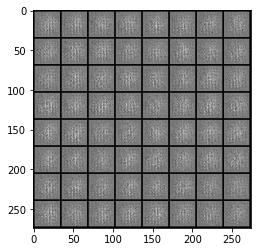

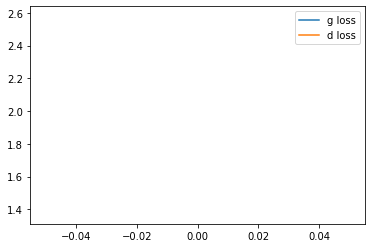

it: 200; g_loss: 3.2637057304382324; d_loss: 0.2058754563331604; avg_real_score: 0.8717259168624878; avg_fake_score: 0.05677563697099686: : 199it [00:09, 22.25it/s]  

generated images


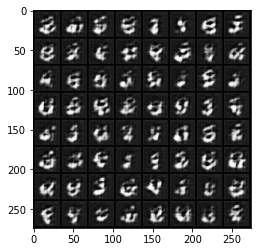

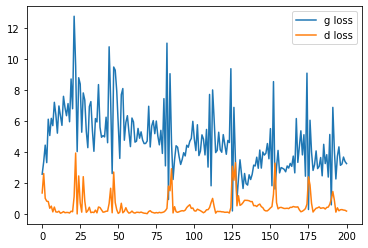

it: 400; g_loss: 2.5224781036376953; d_loss: 0.4009312689304352; avg_real_score: 0.890552282333374; avg_fake_score: 0.09880587458610535: : 400it [00:19, 21.56it/s]

generated images


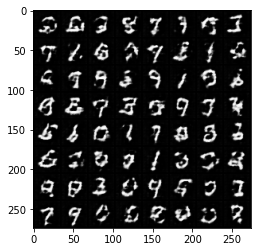

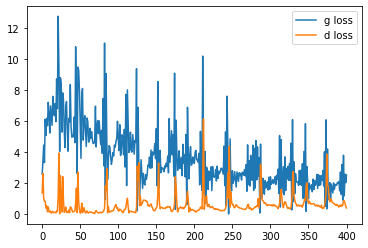

it: 468; g_loss: 2.60361385345459; d_loss: 0.35909390449523926; avg_real_score: 0.8718336820602417; avg_fake_score: 0.08690229058265686: : 469it [00:22, 20.52it/s]
it: 469; g_loss: 1.7547154426574707; d_loss: 0.41821473836898804; avg_real_score: 0.7826851606369019; avg_fake_score: 0.20109347999095917: : 0it [00:00, ?it/s]

generated images


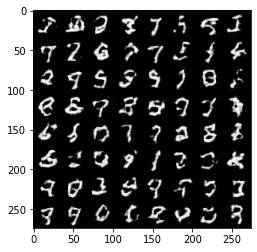

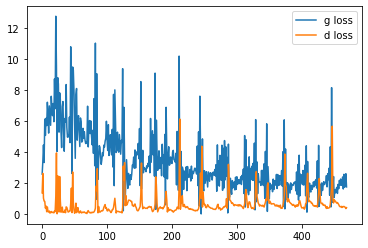

it: 669; g_loss: 1.9495028257369995; d_loss: 0.39994069933891296; avg_real_score: 0.7967738509178162; avg_fake_score: 0.1718059480190277: : 198it [00:09, 21.06it/s]

generated images


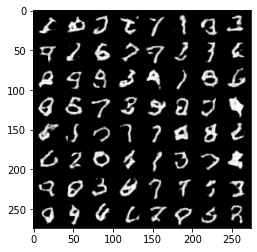

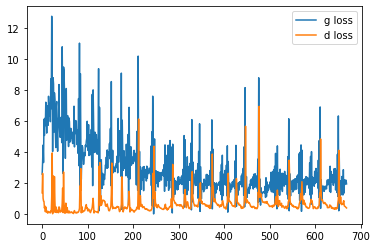

it: 869; g_loss: 2.929196834564209; d_loss: 0.39826953411102295; avg_real_score: 0.9112318754196167; avg_fake_score: 0.06977947056293488: : 399it [00:19, 20.83it/s]

generated images


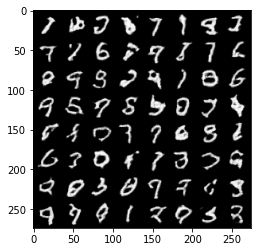

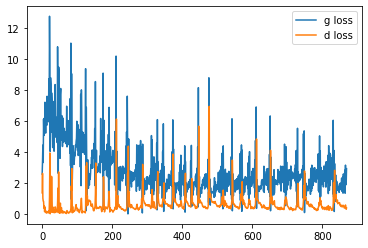

it: 937; g_loss: 1.7730026245117188; d_loss: 0.5303470492362976; avg_real_score: 0.7476052045822144; avg_fake_score: 0.2099922001361847: : 469it [00:23, 20.14it/s]
it: 938; g_loss: 2.198601722717285; d_loss: 0.43001165986061096; avg_real_score: 0.870875358581543; avg_fake_score: 0.13577815890312195: : 0it [00:00, ?it/s]

generated images


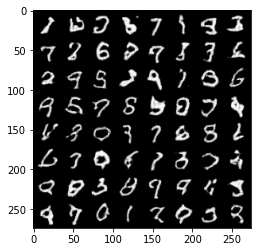

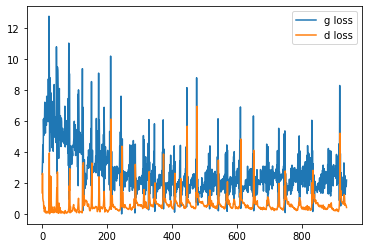

it: 1138; g_loss: 0.706767737865448; d_loss: 5.565721035003662; avg_real_score: 0.007407289929687977; avg_fake_score: 0.5633152723312378: : 200it [00:10, 19.95it/s]  

generated images


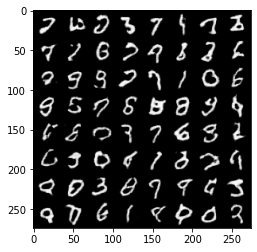

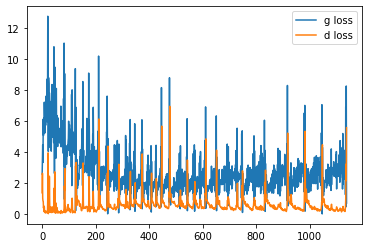

it: 1338; g_loss: 1.6908776760101318; d_loss: 0.2687688171863556; avg_real_score: 0.8189782500267029; avg_fake_score: 0.24909237027168274: : 400it [00:20, 19.99it/s] 

generated images


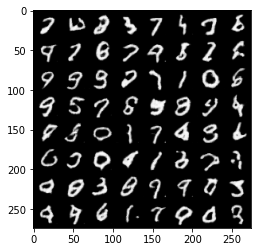

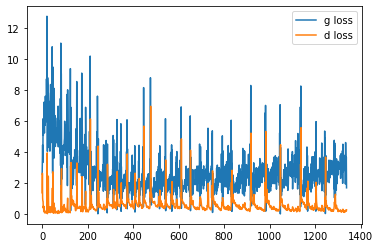

it: 1406; g_loss: 4.752017498016357; d_loss: 0.3535126745700836; avg_real_score: 0.96751868724823; avg_fake_score: 0.01260289829224348: : 469it [00:24, 19.25it/s]
it: 1407; g_loss: 1.9572501182556152; d_loss: 0.5801548957824707; avg_real_score: 0.639331042766571; avg_fake_score: 0.18865570425987244: : 0it [00:00, ?it/s]

generated images


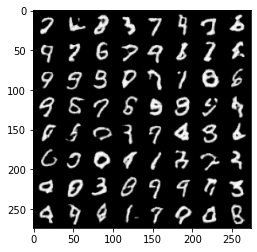

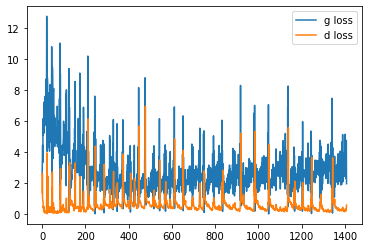

it: 1607; g_loss: 3.0085439682006836; d_loss: 0.3692435622215271; avg_real_score: 0.9424499273300171; avg_fake_score: 0.0693259984254837: : 199it [00:10, 19.50it/s]

generated images


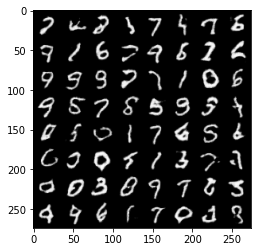

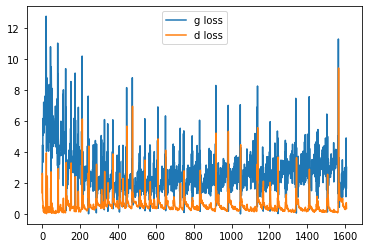

it: 1807; g_loss: 2.387345790863037; d_loss: 0.2564220726490021; avg_real_score: 0.812317430973053; avg_fake_score: 0.14655596017837524: : 399it [00:21, 18.38it/s]  

generated images


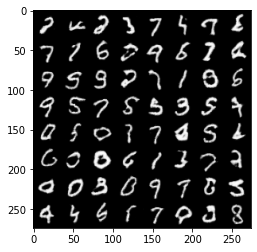

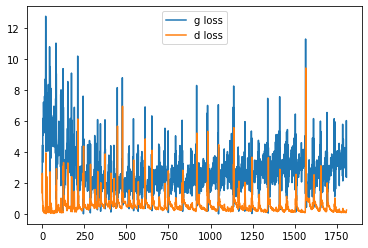

it: 1875; g_loss: 0.4065400958061218; d_loss: 9.431659698486328; avg_real_score: 0.00015894540410954505; avg_fake_score: 0.7230893969535828: : 469it [00:25, 18.50it/s]
it: 1876; g_loss: 2.692213535308838; d_loss: 2.1918113231658936; avg_real_score: 0.8516740798950195; avg_fake_score: 0.10853596031665802: : 0it [00:00, ?it/s]

generated images


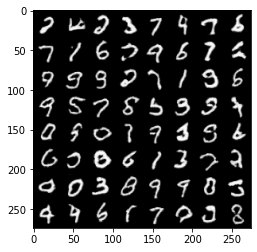

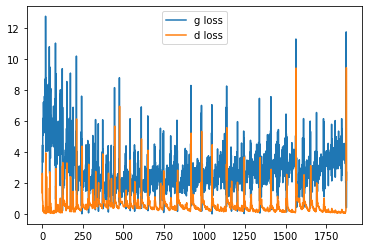

it: 2076; g_loss: 3.9453017711639404; d_loss: 0.1599535048007965; avg_real_score: 0.955665111541748; avg_fake_score: 0.033375129103660583: : 200it [00:10, 19.31it/s]

generated images


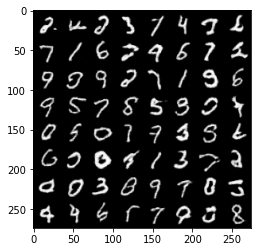

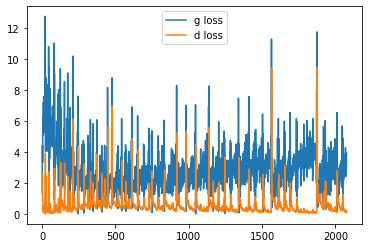

it: 2276; g_loss: 2.9566049575805664; d_loss: 0.1734335571527481; avg_real_score: 0.9262616634368896; avg_fake_score: 0.0828719213604927: : 399it [00:21, 19.00it/s]

generated images


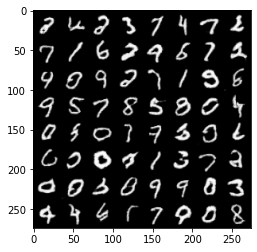

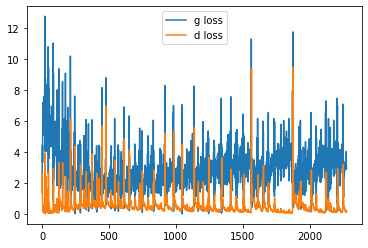

it: 2344; g_loss: 3.597533702850342; d_loss: 0.08897766470909119; avg_real_score: 0.9361563920974731; avg_fake_score: 0.039852604269981384: : 469it [00:26, 18.03it/s]


In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):
    
    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)
        
        cur_batch_size = im.shape[0]  
        
        
        # 1. sample a z vector 

        z = sample_z(cur_batch_size, nz)
        
        # 2. Generate a fake image

        im_fake = netG(z)

        # 3. Classify real image with D

        yhat_real = netD(im)

        # 4. Classify fake image with D

        yhat_fake = netD(im_fake.detach())
       

        ones = get_labels_one(cur_batch_size)
        zeros = get_labels_zero(cur_batch_size)
        
        ###
        ### Discriminator
        ###
        
        d_loss = criterion(yhat_real,ones) + criterion(yhat_fake,zeros) 
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()

        
        ###
        ### Generator
        ###
        for p in netD.parameters():
          p.requires_grad = False
        yhat_fake = netD(im_fake)

        g_loss = criterion(yhat_fake,ones)
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()
        
        for p in netD.parameters():
          p.requires_grad = True
        # Save Metrics
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)
            
            un_norm = renorm(fake_im) # for visualization
            
            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)  
            
            print("generated images")
            plt.imshow(pil_grid)
            plt.show()
            
            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')
            
            plt.legend()
            plt.show()
            
        j += 1

In [ ]:
cifar_train = torchvision.datasets.CIFAR10(root='.', download=True, transform=mytransform)

Files already downloaded and verified


it: 0; g_loss: 1.582589864730835; d_loss: 1.0050265789031982; avg_real_score: 0.6615699529647827; avg_fake_score: 0.2589300572872162: : 0it [00:00, ?it/s]

generated images


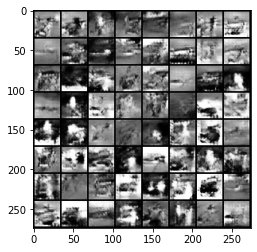

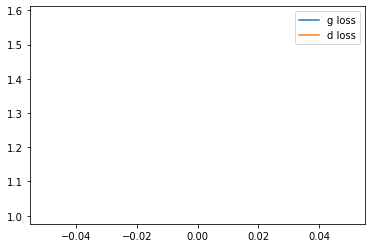

it: 200; g_loss: 1.853151798248291; d_loss: 0.782747745513916; avg_real_score: 0.7374204397201538; avg_fake_score: 0.19373448193073273: : 199it [00:10, 20.66it/s]  

generated images


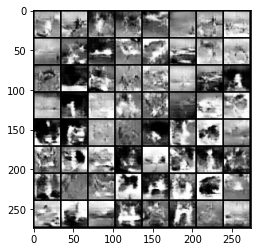

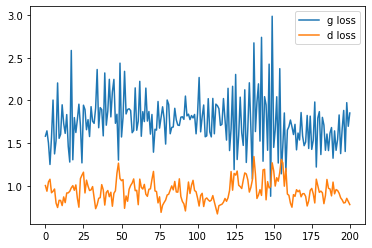

it: 390; g_loss: 1.164095163345337; d_loss: 0.924335241317749; avg_real_score: 0.6199166178703308; avg_fake_score: 0.3603437542915344: : 391it [00:19, 19.76it/s]
it: 391; g_loss: 1.935502052307129; d_loss: 0.943049430847168; avg_real_score: 0.7826284766197205; avg_fake_score: 0.18037527799606323: : 0it [00:00, ?it/s]

generated images


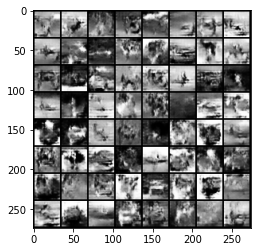

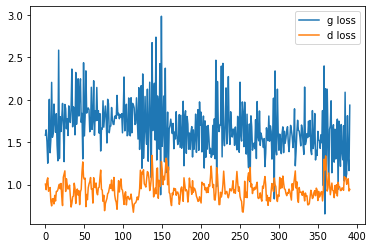

it: 591; g_loss: 1.4126709699630737; d_loss: 1.007539987564087; avg_real_score: 0.597174346446991; avg_fake_score: 0.2800372242927551: : 198it [00:10, 19.03it/s]  

generated images


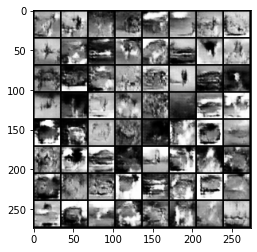

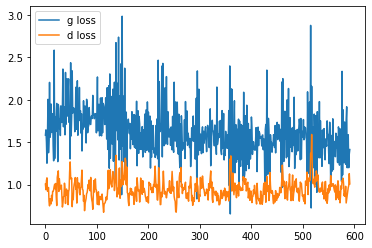

it: 781; g_loss: 1.6470890045166016; d_loss: 0.9164975881576538; avg_real_score: 0.6987436413764954; avg_fake_score: 0.22751140594482422: : 391it [00:20, 18.98it/s]
it: 782; g_loss: 1.6014325618743896; d_loss: 0.8726543188095093; avg_real_score: 0.6678258776664734; avg_fake_score: 0.24495689570903778: : 0it [00:00, ?it/s]

generated images


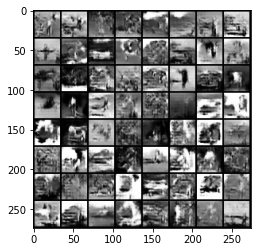

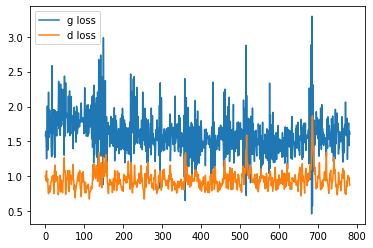

it: 982; g_loss: 1.4207009077072144; d_loss: 0.976707935333252; avg_real_score: 0.6714731454849243; avg_fake_score: 0.28256744146347046: : 200it [00:10, 18.92it/s] 

generated images


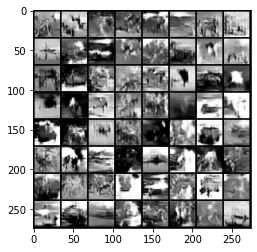

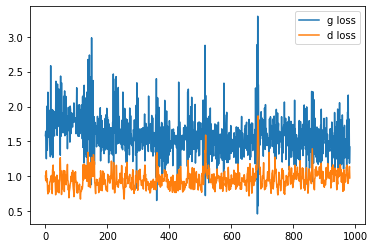

it: 1172; g_loss: 1.62787663936615; d_loss: 0.9982554316520691; avg_real_score: 0.6761072874069214; avg_fake_score: 0.24061046540737152: : 391it [00:21, 18.32it/s]
it: 1173; g_loss: 1.5662894248962402; d_loss: 1.0498292446136475; avg_real_score: 0.6057059168815613; avg_fake_score: 0.25700223445892334: : 0it [00:00, ?it/s]

generated images


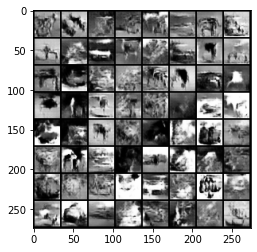

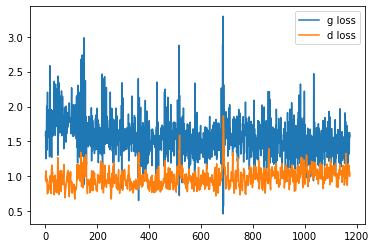

it: 1373; g_loss: 1.3132283687591553; d_loss: 1.0906476974487305; avg_real_score: 0.5985137820243835; avg_fake_score: 0.30269765853881836: : 199it [00:11, 18.57it/s]

generated images


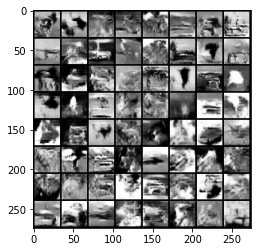

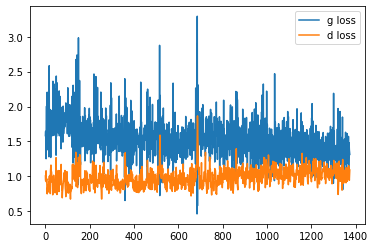

it: 1563; g_loss: 1.0875033140182495; d_loss: 1.2058287858963013; avg_real_score: 0.4058157503604889; avg_fake_score: 0.3709774911403656: : 391it [00:21, 17.78it/s]
it: 1564; g_loss: 1.2767484188079834; d_loss: 0.9998267889022827; avg_real_score: 0.7494906783103943; avg_fake_score: 0.3186761140823364: : 0it [00:00, ?it/s]

generated images


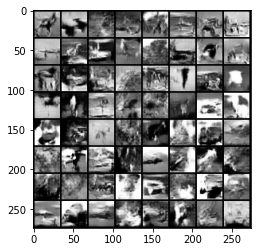

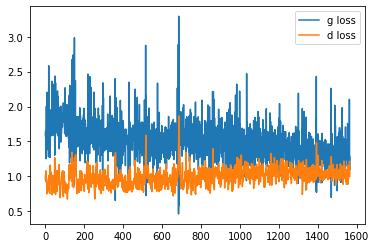

it: 1764; g_loss: 1.5390409231185913; d_loss: 1.0744285583496094; avg_real_score: 0.67870032787323; avg_fake_score: 0.248769149184227: : 200it [00:11, 18.32it/s]   

generated images


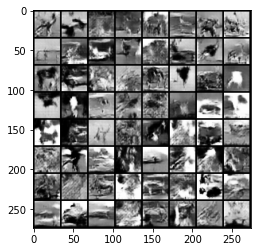

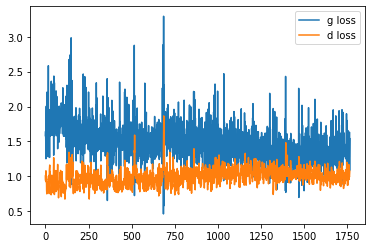

it: 1954; g_loss: 1.4856090545654297; d_loss: 1.0009520053863525; avg_real_score: 0.6319233179092407; avg_fake_score: 0.2632754445075989: : 391it [00:22, 17.23it/s]
it: 1955; g_loss: 1.371415615081787; d_loss: 0.971173107624054; avg_real_score: 0.6259798407554626; avg_fake_score: 0.29540401697158813: : 0it [00:00, ?it/s]

generated images


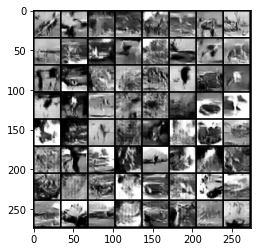

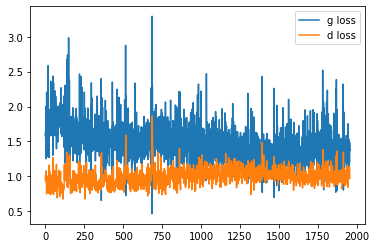

it: 2155; g_loss: 1.3201414346694946; d_loss: 0.9716116189956665; avg_real_score: 0.5686504244804382; avg_fake_score: 0.30691516399383545: : 199it [00:11, 16.64it/s]

generated images


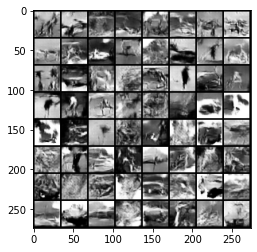

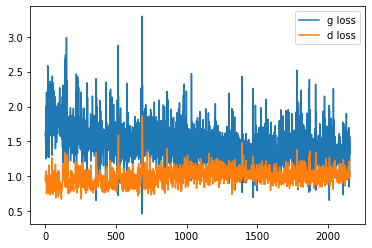

it: 2345; g_loss: 1.9004443883895874; d_loss: 0.896275520324707; avg_real_score: 0.7247189283370972; avg_fake_score: 0.1693117916584015: : 391it [00:23, 16.81it/s]
it: 2346; g_loss: 0.9550842046737671; d_loss: 1.044402003288269; avg_real_score: 0.5165442824363708; avg_fake_score: 0.4181174635887146: : 0it [00:00, ?it/s]

generated images


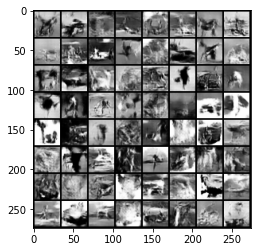

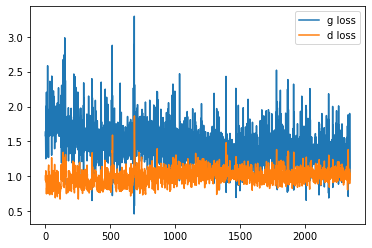

it: 2546; g_loss: 1.8195222616195679; d_loss: 1.1112747192382812; avg_real_score: 0.7548213005065918; avg_fake_score: 0.20099177956581116: : 199it [00:12, 16.90it/s]

generated images


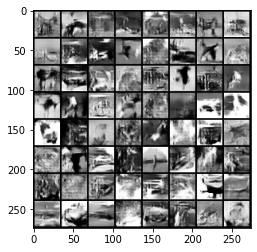

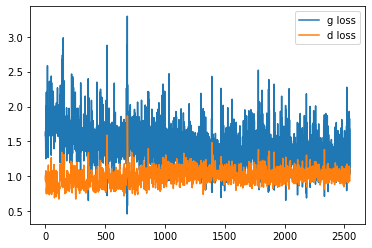

it: 2736; g_loss: 1.261978030204773; d_loss: 1.0048730373382568; avg_real_score: 0.5708271861076355; avg_fake_score: 0.3132864832878113: : 391it [00:23, 16.48it/s]
it: 2737; g_loss: 1.5074083805084229; d_loss: 0.9963405132293701; avg_real_score: 0.7101526260375977; avg_fake_score: 0.25738218426704407: : 0it [00:00, ?it/s]

generated images


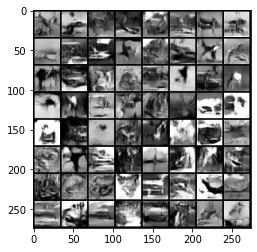

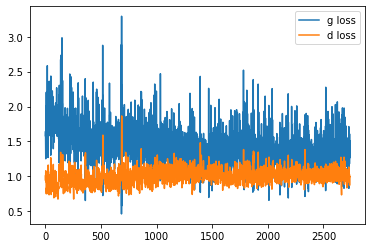

it: 2937; g_loss: 1.4257020950317383; d_loss: 1.082355260848999; avg_real_score: 0.6010446548461914; avg_fake_score: 0.27624836564064026: : 199it [00:12, 17.29it/s] 

generated images


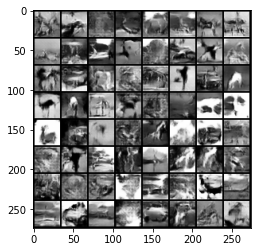

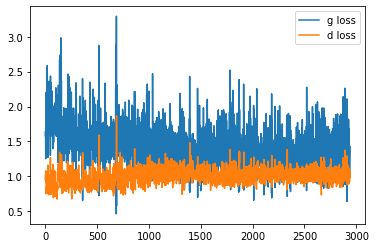

it: 3127; g_loss: 1.0562795400619507; d_loss: 1.1597604751586914; avg_real_score: 0.5107840895652771; avg_fake_score: 0.3779064416885376: : 391it [00:23, 16.59it/s]
it: 3128; g_loss: 1.873798131942749; d_loss: 0.8767441511154175; avg_real_score: 0.7782706022262573; avg_fake_score: 0.19032713770866394: : 0it [00:00, ?it/s]

generated images


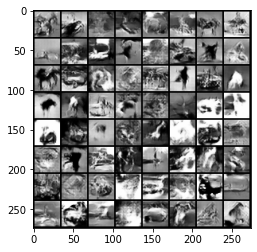

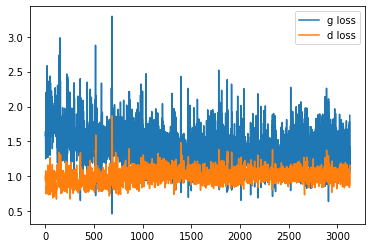

it: 3328; g_loss: 1.2931668758392334; d_loss: 1.1073243618011475; avg_real_score: 0.649669349193573; avg_fake_score: 0.31290769577026367: : 199it [00:12, 17.33it/s]

generated images


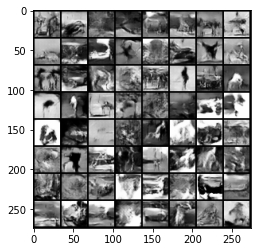

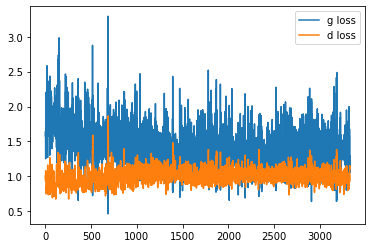

it: 3518; g_loss: 1.1792027950286865; d_loss: 0.9547460079193115; avg_real_score: 0.5765687823295593; avg_fake_score: 0.33691737055778503: : 391it [00:24, 16.20it/s]
it: 3519; g_loss: 1.5635926723480225; d_loss: 1.0076391696929932; avg_real_score: 0.7035887837409973; avg_fake_score: 0.24675098061561584: : 0it [00:00, ?it/s]

generated images


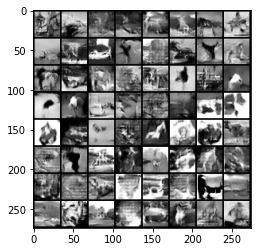

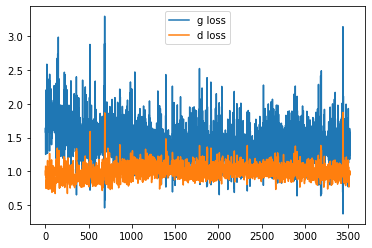

it: 3719; g_loss: 1.8202461004257202; d_loss: 0.9561685919761658; avg_real_score: 0.7332246899604797; avg_fake_score: 0.1870850920677185: : 199it [00:12, 16.21it/s]

generated images


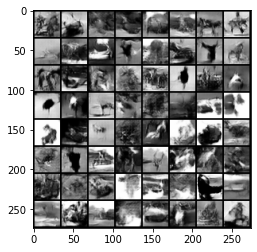

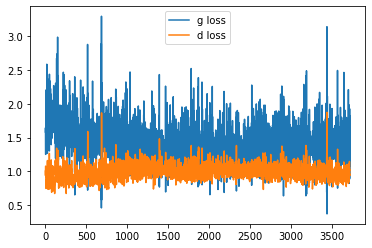

it: 3909; g_loss: 1.4599708318710327; d_loss: 1.0131218433380127; avg_real_score: 0.6881054043769836; avg_fake_score: 0.2566264271736145: : 391it [00:24, 16.17it/s]
it: 3910; g_loss: 1.441468358039856; d_loss: 0.9382436275482178; avg_real_score: 0.6310223340988159; avg_fake_score: 0.26491010189056396: : 0it [00:00, ?it/s]

generated images


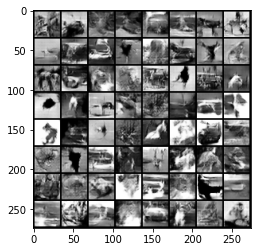

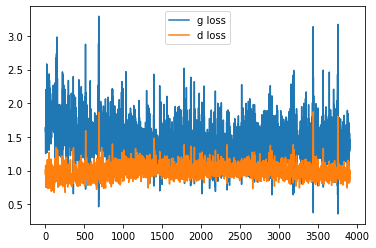

it: 4110; g_loss: 1.5945605039596558; d_loss: 0.9304014444351196; avg_real_score: 0.7037608027458191; avg_fake_score: 0.2441858947277069: : 199it [00:12, 16.43it/s]

generated images


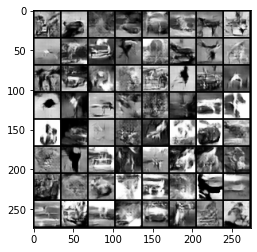

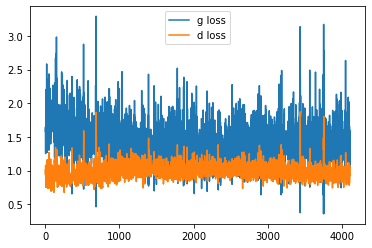

it: 4300; g_loss: 1.4945324659347534; d_loss: 0.8709940910339355; avg_real_score: 0.6071192026138306; avg_fake_score: 0.24727682769298553: : 391it [00:24, 15.83it/s]
it: 4301; g_loss: 1.1138579845428467; d_loss: 0.8495619297027588; avg_real_score: 0.6185804605484009; avg_fake_score: 0.37982580065727234: : 0it [00:00, ?it/s]

generated images


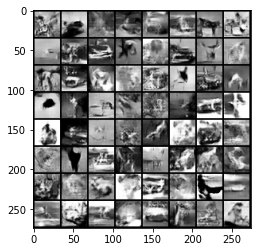

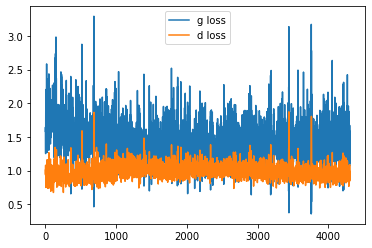

it: 4501; g_loss: 1.2838256359100342; d_loss: 0.8995729684829712; avg_real_score: 0.5784069895744324; avg_fake_score: 0.31478351354599: : 199it [00:12, 16.98it/s]   

generated images


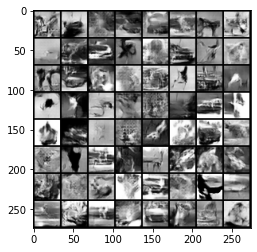

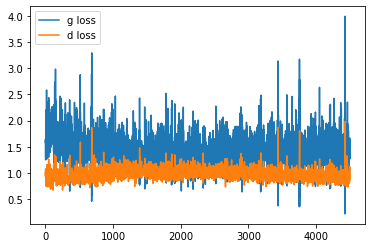

it: 4691; g_loss: 1.6991535425186157; d_loss: 1.0776152610778809; avg_real_score: 0.7066572308540344; avg_fake_score: 0.21209736168384552: : 391it [00:24, 15.77it/s]
it: 4692; g_loss: 1.572702169418335; d_loss: 0.8244263529777527; avg_real_score: 0.6410634517669678; avg_fake_score: 0.24211430549621582: : 0it [00:00, ?it/s]

generated images


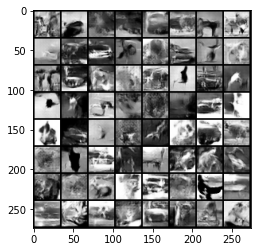

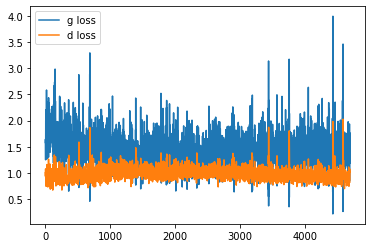

it: 4892; g_loss: 1.1847262382507324; d_loss: 0.9832962155342102; avg_real_score: 0.5710324048995972; avg_fake_score: 0.34823668003082275: : 199it [00:12, 16.91it/s]

generated images


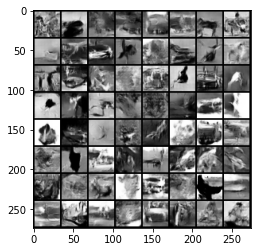

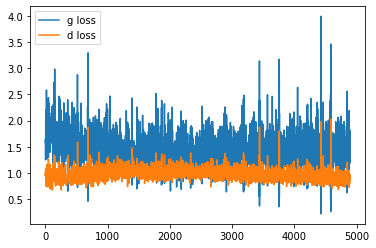

it: 5082; g_loss: 1.236404299736023; d_loss: 1.0097662210464478; avg_real_score: 0.5673742294311523; avg_fake_score: 0.3231261670589447: : 391it [00:24, 15.86it/s]
it: 5083; g_loss: 1.2508591413497925; d_loss: 0.9128178954124451; avg_real_score: 0.657180666923523; avg_fake_score: 0.3229353427886963: : 0it [00:00, ?it/s]

generated images


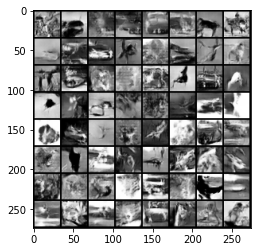

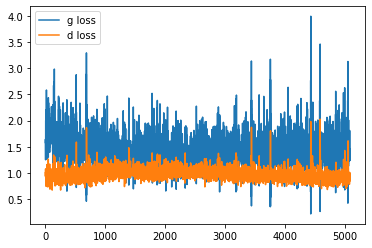

it: 5283; g_loss: 1.3984438180923462; d_loss: 0.8514456152915955; avg_real_score: 0.6906800270080566; avg_fake_score: 0.28356343507766724: : 199it [00:13, 15.38it/s]

generated images


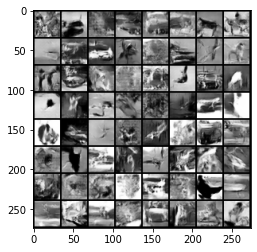

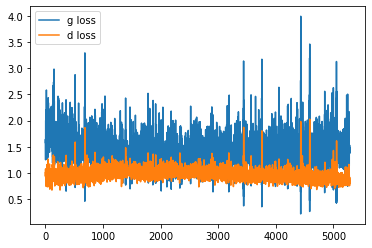

it: 5473; g_loss: 1.7395433187484741; d_loss: 0.9122385382652283; avg_real_score: 0.6946497559547424; avg_fake_score: 0.20310239493846893: : 391it [00:24, 15.67it/s]
it: 5474; g_loss: 1.0010297298431396; d_loss: 0.9653742909431458; avg_real_score: 0.5428470373153687; avg_fake_score: 0.4104610085487366: : 0it [00:00, ?it/s]

generated images


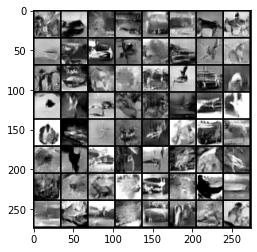

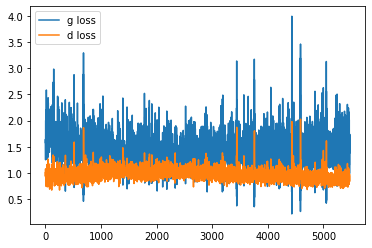

it: 5674; g_loss: 1.2789945602416992; d_loss: 0.8822246193885803; avg_real_score: 0.6226303577423096; avg_fake_score: 0.3214147686958313: : 199it [00:13, 16.13it/s] 

generated images


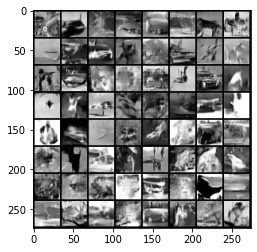

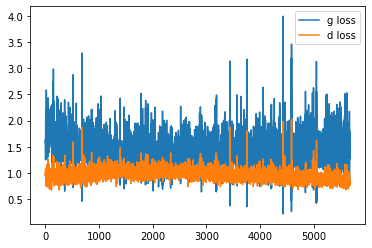

it: 5864; g_loss: 1.3232914209365845; d_loss: 0.8006463050842285; avg_real_score: 0.667742908000946; avg_fake_score: 0.29307079315185547: : 391it [00:25, 15.46it/s]
it: 5865; g_loss: 1.7705740928649902; d_loss: 0.8728299140930176; avg_real_score: 0.7395617961883545; avg_fake_score: 0.20383328199386597: : 0it [00:00, ?it/s]

generated images


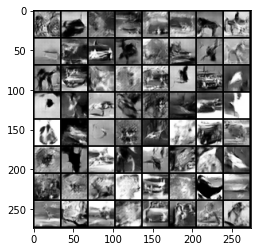

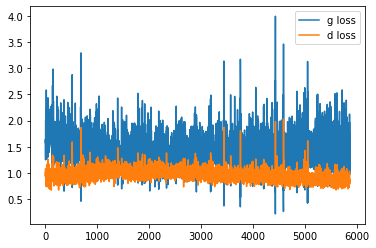

it: 6065; g_loss: 1.3719382286071777; d_loss: 0.7565904855728149; avg_real_score: 0.6451054215431213; avg_fake_score: 0.2862704396247864: : 199it [00:12, 16.09it/s] 

generated images


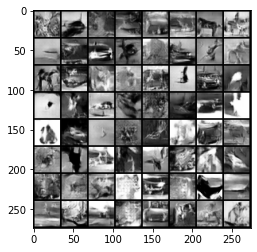

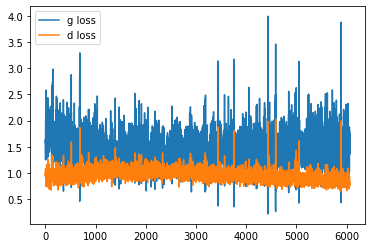

it: 6255; g_loss: 1.3615715503692627; d_loss: 0.9513860940933228; avg_real_score: 0.5724135637283325; avg_fake_score: 0.2943330407142639: : 391it [00:24, 15.64it/s]
it: 6256; g_loss: 1.4360935688018799; d_loss: 0.7733781337738037; avg_real_score: 0.702006459236145; avg_fake_score: 0.29005497694015503: : 0it [00:00, ?it/s]

generated images


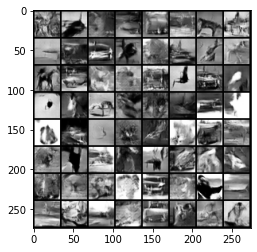

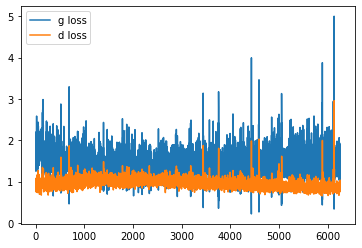

it: 6456; g_loss: 1.5915178060531616; d_loss: 0.750291645526886; avg_real_score: 0.6719379425048828; avg_fake_score: 0.246454119682312: : 199it [00:12, 16.53it/s]   

generated images


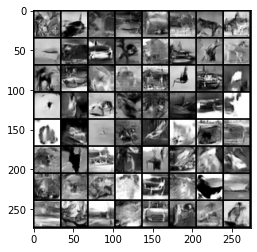

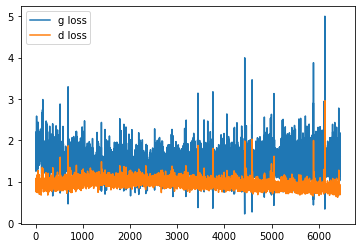

it: 6646; g_loss: 1.0758434534072876; d_loss: 0.79700767993927; avg_real_score: 0.6577555537223816; avg_fake_score: 0.3839484751224518: : 391it [00:25, 15.45it/s]
it: 6647; g_loss: 2.382903575897217; d_loss: 0.8811789751052856; avg_real_score: 0.8588228225708008; avg_fake_score: 0.1224929690361023: : 0it [00:00, ?it/s]

generated images


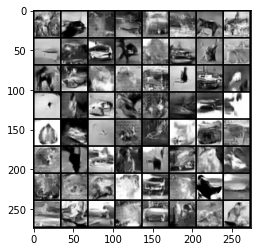

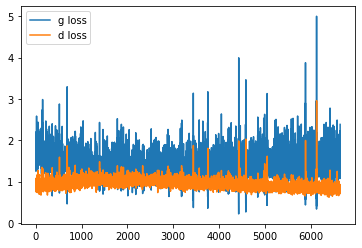

it: 6847; g_loss: 1.2410635948181152; d_loss: 0.9559560418128967; avg_real_score: 0.5074697732925415; avg_fake_score: 0.33237069845199585: : 199it [00:13, 15.69it/s]

generated images


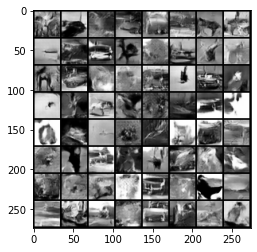

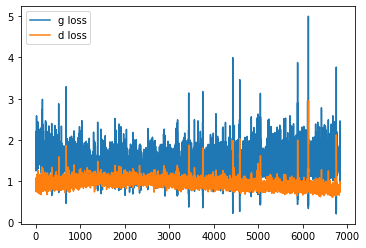

it: 7037; g_loss: 1.7005385160446167; d_loss: 0.7192931175231934; avg_real_score: 0.7250369787216187; avg_fake_score: 0.207350954413414: : 391it [00:26, 15.04it/s]
it: 7038; g_loss: 1.6022666692733765; d_loss: 0.6819213032722473; avg_real_score: 0.7093424201011658; avg_fake_score: 0.24186167120933533: : 0it [00:00, ?it/s]

generated images


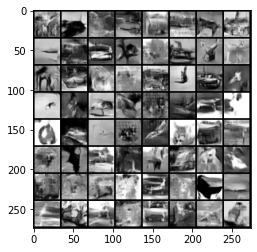

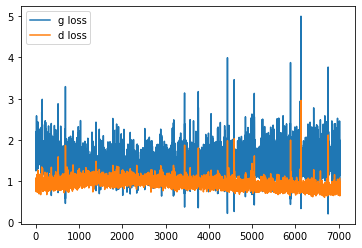

it: 7238; g_loss: 1.9305226802825928; d_loss: 0.8034652471542358; avg_real_score: 0.8034224510192871; avg_fake_score: 0.17918087542057037: : 199it [00:13, 16.20it/s]

generated images


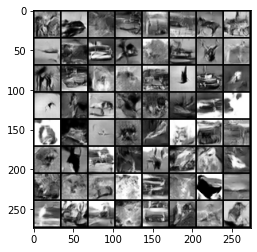

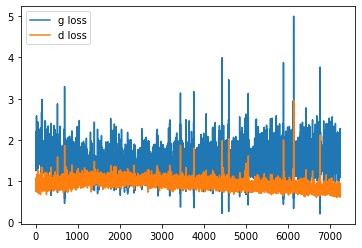

it: 7428; g_loss: 0.9580820202827454; d_loss: 1.1345021724700928; avg_real_score: 0.47937819361686707; avg_fake_score: 0.427041620016098: : 391it [00:25, 15.25it/s]
it: 7429; g_loss: 1.9591270685195923; d_loss: 1.1677110195159912; avg_real_score: 0.7581219673156738; avg_fake_score: 0.18417461216449738: : 0it [00:00, ?it/s]

generated images


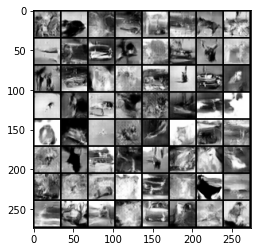

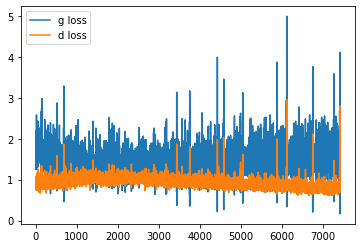

it: 7629; g_loss: 1.4104187488555908; d_loss: 0.7984944581985474; avg_real_score: 0.6645539999008179; avg_fake_score: 0.2856890857219696: : 199it [00:13, 15.01it/s]

generated images


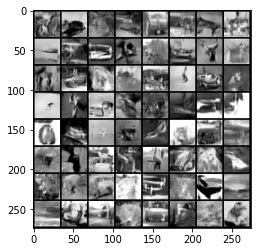

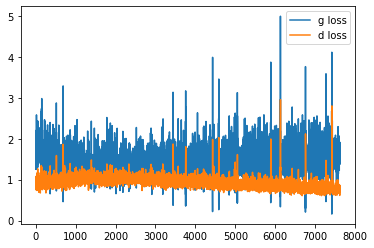

it: 7819; g_loss: 1.8528854846954346; d_loss: 0.8525989055633545; avg_real_score: 0.7070969939231873; avg_fake_score: 0.19504734873771667: : 391it [00:25, 15.09it/s]
it: 7820; g_loss: 1.843536138534546; d_loss: 0.6285086870193481; avg_real_score: 0.7276923656463623; avg_fake_score: 0.20704251527786255: : 0it [00:00, ?it/s]

generated images


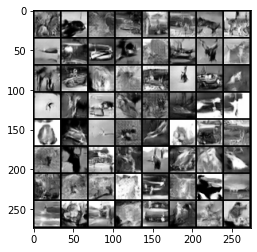

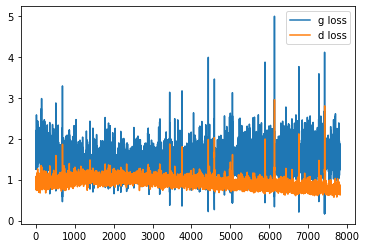

it: 8020; g_loss: 1.2692722082138062; d_loss: 1.0081441402435303; avg_real_score: 0.5524304509162903; avg_fake_score: 0.3291131854057312: : 199it [00:13, 16.26it/s]

generated images


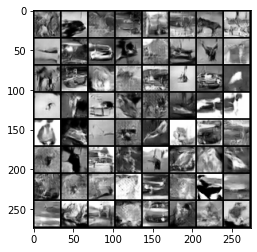

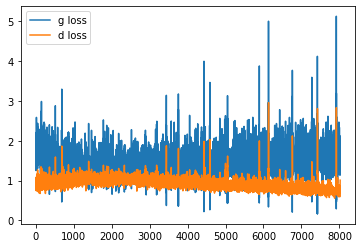

it: 8210; g_loss: 1.6637972593307495; d_loss: 0.6190348267555237; avg_real_score: 0.8073620796203613; avg_fake_score: 0.2148105651140213: : 391it [00:25, 15.25it/s]
it: 8211; g_loss: 2.061373710632324; d_loss: 0.7560640573501587; avg_real_score: 0.7714840173721313; avg_fake_score: 0.15710824728012085: : 0it [00:00, ?it/s]

generated images


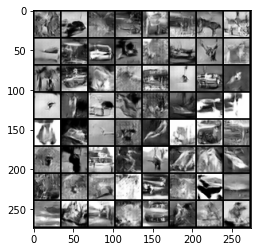

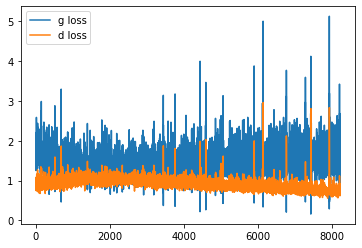

it: 8411; g_loss: 1.2852226495742798; d_loss: 0.8443168997764587; avg_real_score: 0.5928817987442017; avg_fake_score: 0.3313492238521576: : 199it [00:12, 16.45it/s]

generated images


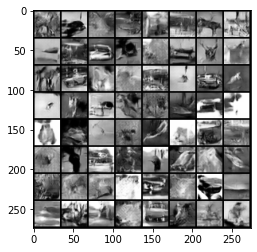

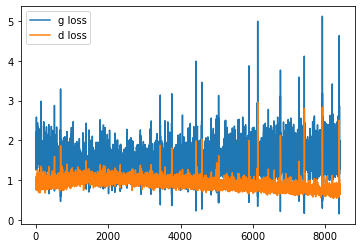

it: 8601; g_loss: 2.4549007415771484; d_loss: 0.7615107297897339; avg_real_score: 0.8015861511230469; avg_fake_score: 0.1224193349480629: : 391it [00:25, 15.51it/s]
it: 8602; g_loss: 0.6967347860336304; d_loss: 0.9118580222129822; avg_real_score: 0.5536314845085144; avg_fake_score: 0.5348378419876099: : 0it [00:00, ?it/s]

generated images


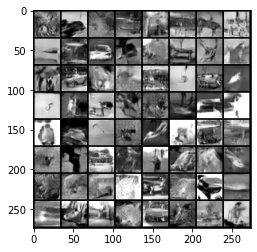

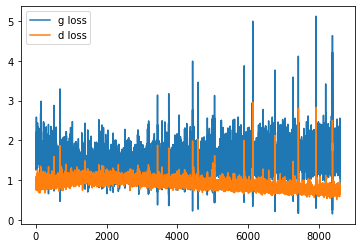

it: 8802; g_loss: 1.3710522651672363; d_loss: 0.8651999831199646; avg_real_score: 0.5212917923927307; avg_fake_score: 0.3025013208389282: : 199it [00:13, 15.33it/s] 

generated images


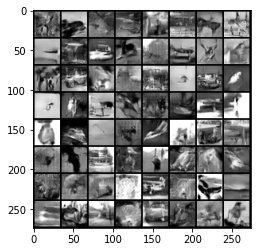

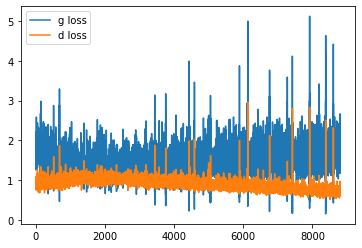

it: 8992; g_loss: 1.809482455253601; d_loss: 0.7620480060577393; avg_real_score: 0.721441388130188; avg_fake_score: 0.19915173947811127: : 391it [00:26, 14.63it/s]
it: 8993; g_loss: 1.637413740158081; d_loss: 0.7250217199325562; avg_real_score: 0.7163451910018921; avg_fake_score: 0.24155519902706146: : 0it [00:00, ?it/s]

generated images


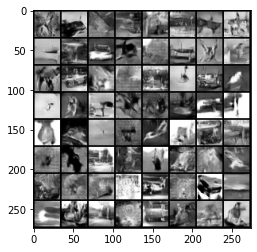

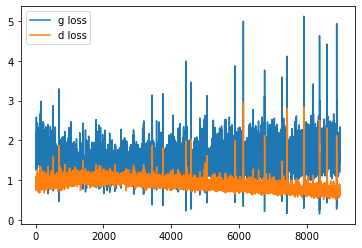

it: 9193; g_loss: 1.3112900257110596; d_loss: 0.7894710898399353; avg_real_score: 0.6036601066589355; avg_fake_score: 0.32199275493621826: : 199it [00:14, 14.94it/s]

generated images


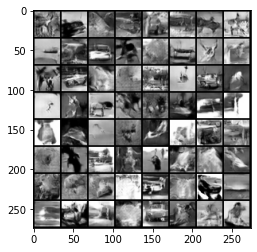

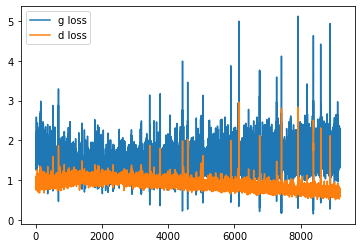

it: 9383; g_loss: 2.614375352859497; d_loss: 0.7938377857208252; avg_real_score: 0.7938807010650635; avg_fake_score: 0.10061106830835342: : 391it [00:27, 14.08it/s]
it: 9384; g_loss: 1.045213222503662; d_loss: 0.9142576456069946; avg_real_score: 0.5022389888763428; avg_fake_score: 0.39180269837379456: : 0it [00:00, ?it/s]

generated images


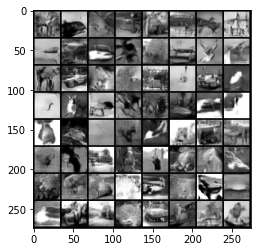

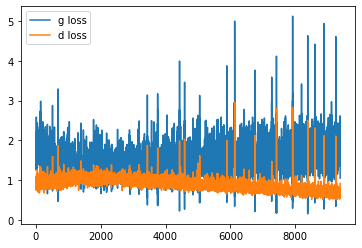

it: 9584; g_loss: 1.8459985256195068; d_loss: 0.8135859966278076; avg_real_score: 0.7505000829696655; avg_fake_score: 0.20396213233470917: : 199it [00:13, 16.25it/s]

generated images


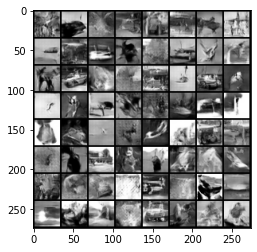

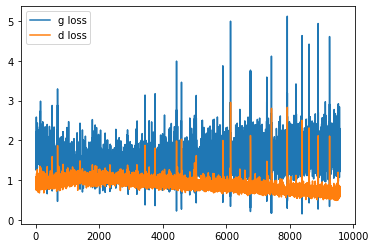

it: 9774; g_loss: 2.4279086589813232; d_loss: 0.5910510420799255; avg_real_score: 0.8294187784194946; avg_fake_score: 0.11849812418222427: : 391it [00:25, 15.18it/s]
it: 9775; g_loss: 1.5893898010253906; d_loss: 0.6536098718643188; avg_real_score: 0.6694967150688171; avg_fake_score: 0.26193487644195557: : 0it [00:00, ?it/s]

generated images


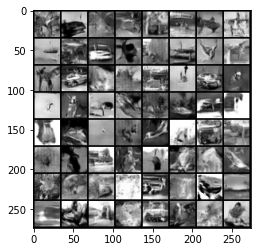

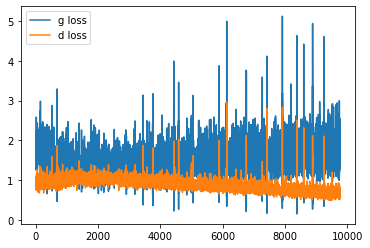

it: 9975; g_loss: 1.0746484994888306; d_loss: 0.858777642250061; avg_real_score: 0.563896894454956; avg_fake_score: 0.388984739780426: : 199it [00:13, 15.88it/s]  

generated images


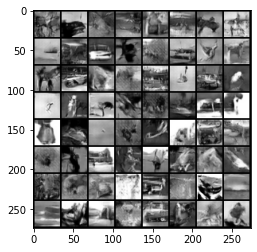

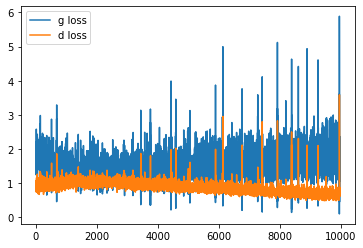

it: 10165; g_loss: 1.774817705154419; d_loss: 0.6009669303894043; avg_real_score: 0.7408101558685303; avg_fake_score: 0.20698170363903046: : 391it [00:25, 15.04it/s]
it: 10166; g_loss: 1.9428715705871582; d_loss: 0.6468846201896667; avg_real_score: 0.7836470007896423; avg_fake_score: 0.1820661425590515: : 0it [00:00, ?it/s]

generated images


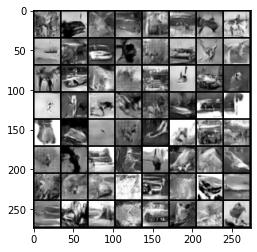

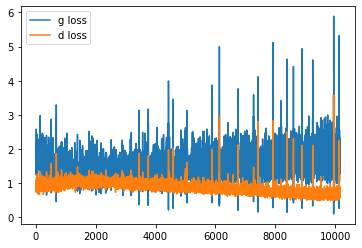

it: 10366; g_loss: 2.2486801147460938; d_loss: 0.5923988223075867; avg_real_score: 0.8067318797111511; avg_fake_score: 0.13784882426261902: : 199it [00:12, 16.11it/s]

generated images


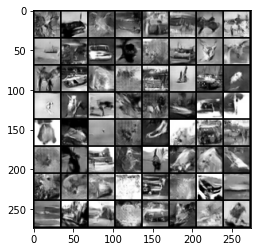

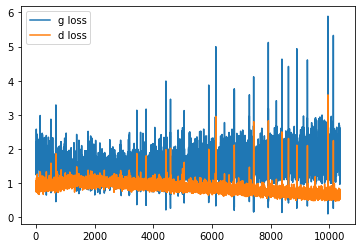

it: 10556; g_loss: 2.6444318294525146; d_loss: 0.8586281538009644; avg_real_score: 0.8456239700317383; avg_fake_score: 0.10064201802015305: : 391it [00:25, 15.37it/s]
it: 10557; g_loss: 1.7379069328308105; d_loss: 0.7277910113334656; avg_real_score: 0.63735032081604; avg_fake_score: 0.22022341191768646: : 0it [00:00, ?it/s]

generated images


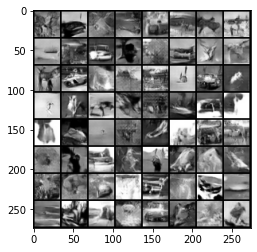

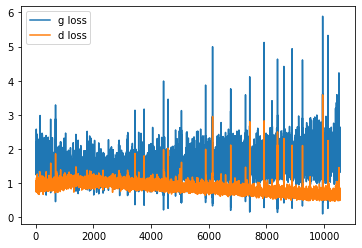

it: 10757; g_loss: 2.4785380363464355; d_loss: 0.6531274318695068; avg_real_score: 0.873848557472229; avg_fake_score: 0.11539734899997711: : 199it [00:13, 15.56it/s]

generated images


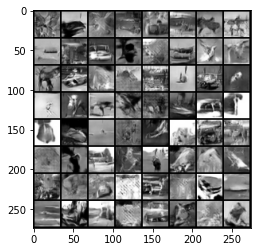

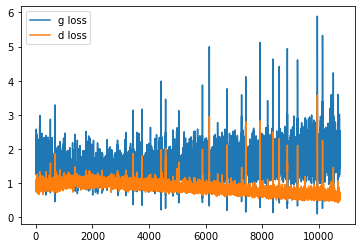

it: 10947; g_loss: 1.714747428894043; d_loss: 0.5616242289543152; avg_real_score: 0.6867600679397583; avg_fake_score: 0.23465196788311005: : 391it [00:26, 14.95it/s]
it: 10948; g_loss: 2.1338024139404297; d_loss: 0.6725824475288391; avg_real_score: 0.8231009244918823; avg_fake_score: 0.1556684672832489: : 0it [00:00, ?it/s]

generated images


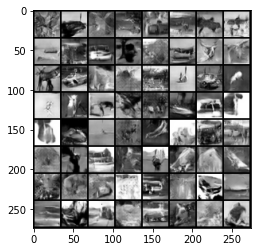

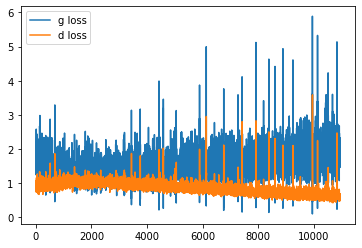

it: 11148; g_loss: 1.4880454540252686; d_loss: 0.5777537226676941; avg_real_score: 0.7554102540016174; avg_fake_score: 0.2748411297798157: : 199it [00:13, 16.52it/s]

generated images


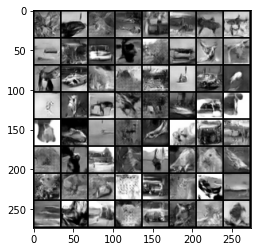

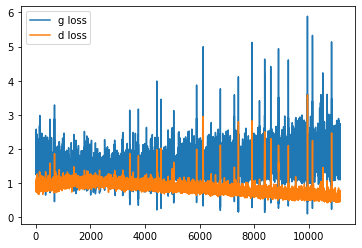

it: 11338; g_loss: 2.426074981689453; d_loss: 0.5142085552215576; avg_real_score: 0.8725605010986328; avg_fake_score: 0.12217096239328384: : 391it [00:25, 15.29it/s]
it: 11339; g_loss: 2.288857936859131; d_loss: 0.5759731531143188; avg_real_score: 0.7758148908615112; avg_fake_score: 0.13555550575256348: : 0it [00:00, ?it/s]

generated images


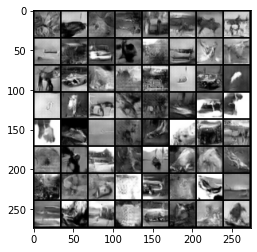

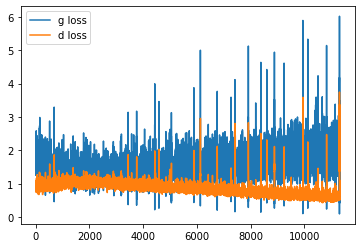

it: 11539; g_loss: 1.5181496143341064; d_loss: 0.6098545789718628; avg_real_score: 0.7761133313179016; avg_fake_score: 0.27601951360702515: : 199it [00:13, 15.72it/s]

generated images


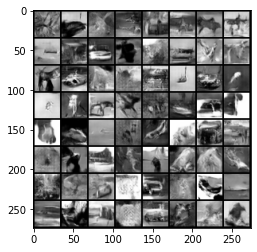

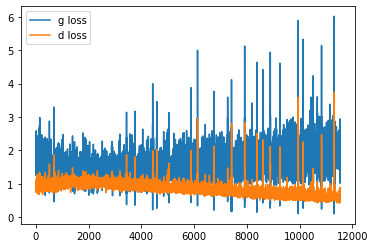

it: 11729; g_loss: 1.5413821935653687; d_loss: 0.6802568435668945; avg_real_score: 0.6134558916091919; avg_fake_score: 0.26514729857444763: : 391it [00:25, 15.17it/s]


In [ ]:
mytransform = transforms.Compose([transforms.Resize(32),
                                  transforms.ToTensor(),
                                  transforms.Normalize((.5), (.5)) # normalize between [-1, 1] with tanh activation
                                 ]) 
dataloader = DataLoader(dataset=cifar_train, 
                         batch_size=batch_size,
                         shuffle=True)  
# plot some images
real_batch, real_labels = next(iter(dataloader))  
plt.imshow(transforms.ToPILImage()(make_grid(real_batch)))


nb_epochs = 30

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):
    
    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)
        
        cur_batch_size = im.shape[0]  
        
        
        
        # 1. sample a z vector 

        z = sample_z(cur_batch_size, nz)
        
        # 2. Generate a fake image

        im_fake = netG(z)

        # 3. Classify real image with D
  
        yhat_real = netD(im[:,0,:,:].unsqueeze(1))

        # 4. Classify fake image with D

        yhat_fake = netD(im_fake.detach())
       

        ones = get_labels_one(cur_batch_size)
        zeros = get_labels_zero(cur_batch_size)
        
        ###
        ### Discriminator
        ###
        
        d_loss = criterion(yhat_real,ones) + criterion(yhat_fake,zeros)  #YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()

        
        ###
        ### Generator
        ###
        for p in netD.parameters():
          p.requires_grad = False
        yhat_fake = netD(im_fake)

        g_loss = criterion(yhat_fake,ones) #YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()
        
        for p in netD.parameters():
          p.requires_grad = True
        # Save Metrics
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)
            
            un_norm = renorm(fake_im) # for visualization
            
            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)  
            
            print("generated images")
            plt.imshow(pil_grid)
            plt.show()
            
            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')
            
            plt.legend()
            plt.show()
            
        j += 1
